In [1]:
%reload_ext autoreload
%reload_ext rpy2.ipython

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.sparse as sps

from ampute import ampute_mcar, ampute_mar
from coclust_mod_impute import (CoclustModImpute,
                                summarize_blocks, get_block_counts,
                                _impute_block_representative)
from utils import show_matrix

In [3]:
%%R
# library(mice)
library(missMDA)
library(FactoMineR)

In [4]:
%%R
data('binarydata', package='blockcluster')
X <- binarydata

In [5]:
X = np.array([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]])
X = X[np.ix_([0, 2, 7, 1, 4, 8, 3, 5, 6],
             [ 0,  4,  5, 15,  8,  9, 12, 13,  7, 10,  1,  2,  3,  6, 11, 14])]

n_clusters = 3
w = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2])
z = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

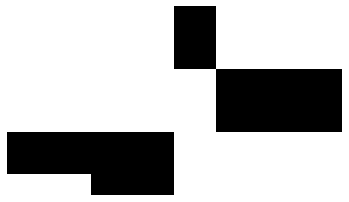

In [6]:
show_matrix(X)

In [7]:
res, r_nan, c_nan = ampute_mcar(X, .2)
print(np.isnan(res).sum())
print(res)

28
[[ 0.  0. nan  0.  0.  0.  0.  0.  1.  1.  0.  0.  0. nan nan  0.]
 [ 0. nan  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [nan  0.  0.  0.  0.  0. nan  0.  1.  1.  0.  0. nan nan  0.  0.]
 [nan  0. nan nan  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.]
 [nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [nan  0.  0.  0.  0.  0.  0.  0. nan nan  1.  1.  1.  1. nan nan]
 [ 1.  1.  1.  1. nan  1.  1.  1.  0.  0.  0.  0.  0.  0.  0. nan]
 [ 1.  1. nan nan nan  1.  1.  1.  0. nan  0.  0.  0.  0.  0.  0.]
 [nan  0. nan  0.  1.  1. nan  1.  0.  0.  0.  0.  0.  0. nan  0.]]


In [8]:
z_labels = np.arange(n_clusters)[:, np.newaxis]
w_labels = z_labels

Z = (z == z_labels).T
W = (w == w_labels).T

In [9]:
summarize_blocks(X, Z, W)

array([[ 0,  6,  0],
       [ 0,  0, 18],
       [20,  0,  0]])

In [10]:
get_block_counts(Z, W)

array([[24,  6, 18],
       [24,  6, 18],
       [24,  6, 18]])

In [11]:
Z.shape, W.shape

((9, 3), (16, 3))

In [12]:
block_rep_vals = summarize_blocks(X, Z, W) / get_block_counts(Z, W)
block_rep_vals

array([[0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.83333333, 0.        , 0.        ]])

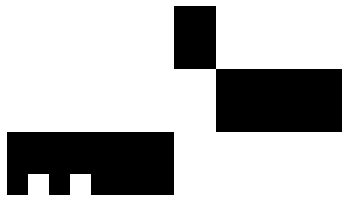

In [13]:
tmp = res.copy()
tmp[r_nan, c_nan] = block_rep_vals[z[r_nan],w[c_nan]]
show_matrix(tmp)

In [14]:
print(np.round(tmp[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[0.83 0.   0.   0.   0.83 0.   0.   0.83 0.   0.   0.   0.   0.83 0.
 0.   0.   0.   0.   0.83 0.   0.   0.   1.   1.   1.   0.83 0.   0.83]
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1]


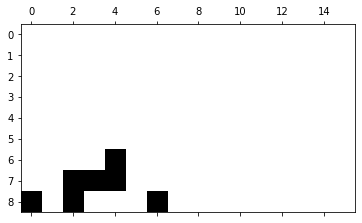

In [15]:
show_matrix(np.abs(X-tmp), no_axes=False)

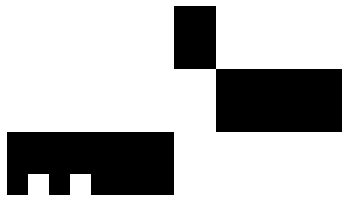

In [16]:
XW = X @ W
# cls = np.argmax(XW, axis=1)
# Z = cls == z_labels
# print(XW)

na_rep = XW / W.sum(axis=0)
# print(np.round(na_rep,5))
X_nan = res.copy()
X_nan[r_nan, c_nan] = (na_rep @ W.T)[r_nan, c_nan]

show_matrix(X_nan)

# print(np.round(W.T @ na_rep,2).T[nan_mask])



In [17]:
print(np.round(X_nan[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[0.5 0.  0.  0.  1.  0.  0.  0.5 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
 1.  0.  0.  0.  1.  1.  1.  0.5 0.  1. ]
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1]


SSE: 0.75
rounded error matrix


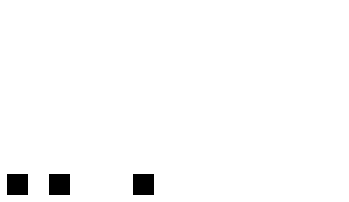

In [18]:
diff = np.abs(X-X_nan)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff)

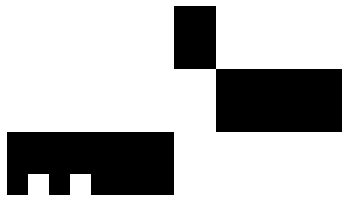

In [19]:
XtZ = X.T @ Z

na_rep = XtZ / Z.sum(axis=0)
# print(np.round(na_rep,5))
X_nan = res.copy()
X_nan[r_nan, c_nan] = (Z @ na_rep.T)[r_nan, c_nan]

show_matrix(X_nan)

In [20]:
print(np.round(X_nan[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[0.67 0.   0.   0.   0.67 0.   0.   0.67 0.   0.   0.   0.   1.   0.
 0.   0.   0.   0.   0.67 0.   0.   0.   1.   1.   1.   1.   0.   1.  ]
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1]


SSE: 1.1111111111111112
rounded error matrix


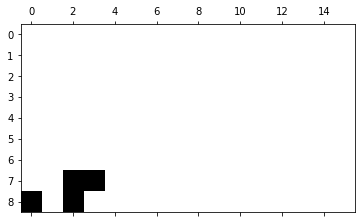

In [21]:
diff = np.abs(X-X_nan)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff, no_axes=False)

## Modification de CoClustMod

In [22]:
# -*- coding: utf-8 -*-

"""
The :mod:`coclust.coclustering.coclust_mod` module provides an implementation
of a co-clustering algorithm by direct maximization of graph modularity.
"""

# Author: Francois Role <francois.role@gmail.com>
#         Stanislas Morbieu <stanislas.morbieu@gmail.com>

# License: BSD 3 clause



'\nThe :mod:`coclust.coclustering.coclust_mod` module provides an implementation\nof a co-clustering algorithm by direct maximization of graph modularity.\n'

In [23]:
X_missing, r_nan, c_nan = ampute_mar(X, .2)

Percentage of newly generated mising values: 0.2013888888888889


In [24]:
%%R -i X_missing -o ca_imputed
ca_imputed <- imputeCA(X_missing, ncp=2)

In [25]:
init_vals = ca_imputed[r_nan, c_nan]

In [26]:
model = CoclustModImpute(n_clusters=3)
print(X_missing)

[[ 0. nan  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0. nan nan  0.  0.  0.]
 [ 0.  0. nan nan  0. nan  0. nan  0.  0.  1. nan  1. nan nan  1.]
 [ 0.  0. nan nan  0. nan  0.  0.  0.  0.  1. nan  1. nan  1.  1.]
 [ 0.  0. nan nan  0.  0.  0. nan  0.  0.  1. nan  1. nan  1.  1.]
 [nan  1.  1.  1.  1. nan nan  1.  0. nan  0.  0.  0.  0.  0.  0.]
 [nan  1.  1.  1.  1. nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [nan  0.  0.  0.  1.  1. nan  1.  0. nan  0.  0.  0.  0.  0.  0.]]


In [27]:
model.fit(X_missing, _impute_block_representative, initial_vals=init_vals)
# model.fit(X_missing, _impute_block_representative, initial_vals=None)

/mnt/c/Users/user/Documents/_Masters/Cours/M2/Innovation/Projet_Innovation/coclust_mod_impute.py:219: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


CoclustModImpute(init=None, max_iter=20, n_clusters=3, n_init=1, n_jobs=1,
                 random_state=None, tol=1e-09)

SSE: 3.8571428570890474
rounded error matrix


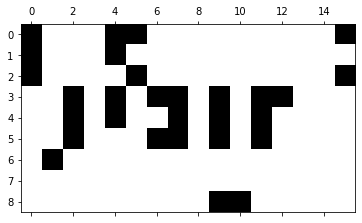

In [28]:
diff = np.abs(X-model.X_)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))], no_axes=False)

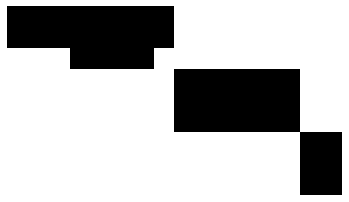

In [29]:
show_matrix(X[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])

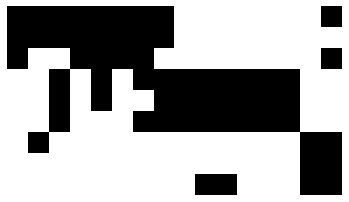

In [30]:
show_matrix(model.X_[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])

## Test on real dataset

In [31]:
mat = sio.loadmat('data/classic3.mat')

In [32]:
[*mat]

['__header__', '__version__', '__globals__', 'A', 'ts', 'ms', 'labels', 'cK']

In [33]:
# mat['ms']#.shape

In [34]:
# X = mat['fea']
X = mat['A'].toarray()
n_clusters = 3

In [35]:
X_missing, r_nan, c_nan = ampute_mcar(X, .3)

In [36]:
# %%R -i X_missing -o ca_imputed
# ca_imputed <- imputeCA(X_missing, ncp=2)

In [37]:
# init_vals = ca_imputed[r_nan, c_nan]

In [38]:
model = CoclustModImpute(n_clusters=n_clusters, n_init=10)
# model.fit(X_missing, _impute_block_representative, initial_vals=init_vals)
model.fit(X_missing, _impute_block_representative, initial_vals=None)

/mnt/c/Users/user/Documents/_Masters/Cours/M2/Innovation/Projet_Innovation/coclust_mod_impute.py:219: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=False, estimator=None)


CoclustModImpute(init=None, max_iter=20, n_clusters=3, n_init=10, n_jobs=1,
                 random_state=None, tol=1e-09)

RMSE: 0.1852474062956833
rounded error matrix


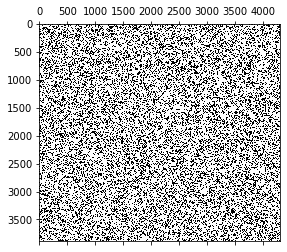

In [39]:
diff = np.abs(X-model.X_)
print(f"RMSE: {((diff**2).sum()/r_nan.shape[0])**.5}")
print("rounded error matrix")
show_matrix(diff[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))], no_axes=False)

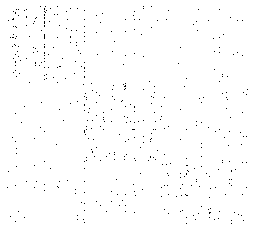

In [40]:
show_matrix(X[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])

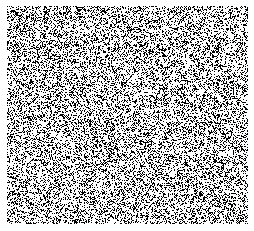

In [41]:
show_matrix(model.X_[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])